# Gradient-Based Attribution

This notebook demonstrates gradient-based interpretability techniques to understand which input features are most important for model predictions.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [3]:
# Load MNIST data
transform = transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [4]:
def train_model(model, train_loader, epochs=5):
    """Train the MNIST model"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {total_loss/len(train_loader):.4f}')
    
    print("Training completed!")

## Simple Gradient Attribution

Compute gradients of the output with respect to the input to see which pixels are most important.

In [5]:
def compute_input_gradients(model, input_tensor, target_class):
    """Compute gradients of output w.r.t. input to see important pixels"""
    input_tensor.requires_grad_(True)
    
    output = model(input_tensor)
    loss = output[0, target_class]
    loss.backward()
    
    gradients = input_tensor.grad.data.abs()
    return gradients

def visualize_gradient_attribution(model, test_loader, num_samples=5):
    """Visualize which pixels are most important for predictions"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    sample_count = 0
    for data, target in test_loader:
        if sample_count >= num_samples:
            break
            
        for i in range(min(data.size(0), num_samples - sample_count)):
            img = data[i:i+1]
            true_label = target[i].item()
            
            # Get prediction
            with torch.no_grad():
                pred = model(img).argmax().item()
            
            # Compute gradients
            gradients = compute_input_gradients(model, img.clone(), pred)
            
            # Plot original, gradients, and overlay
            img_np = img.squeeze().cpu().numpy()
            grad_np = gradients.squeeze().cpu().numpy()
            
            row = sample_count + i
            
            axes[row, 0].imshow(img_np, cmap='gray')
            axes[row, 0].set_title(f'Original (True: {true_label}, Pred: {pred})')
            axes[row, 0].axis('off')
            
            axes[row, 1].imshow(grad_np, cmap='hot')
            axes[row, 1].set_title('Gradient Magnitude')
            axes[row, 1].axis('off')
            
            axes[row, 2].imshow(img_np, cmap='gray', alpha=0.7)
            axes[row, 2].imshow(grad_np, cmap='hot', alpha=0.3)
            axes[row, 2].set_title('Overlay')
            axes[row, 2].axis('off')
        
        sample_count += min(data.size(0), num_samples - sample_count)
    
    plt.tight_layout()
    plt.show()

## Integrated Gradients

A more sophisticated attribution method that integrates gradients along a path from a baseline to the input.

In [21]:
def integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    """Compute integrated gradients for better attribution"""
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    
    # Generate path from baseline to input
    alphas = torch.linspace(0, 1, steps)
    
    integrated_grads = torch.zeros_like(input_tensor)
    
    for alpha in alphas:
        # Interpolate between baseline and input
        interpolated = baseline + alpha * (input_tensor - baseline)
        interpolated.requires_grad_(True)
        
        # Compute gradients
        output = model(interpolated)
        loss = output[0, target_class]
        
        gradients = torch.autograd.grad(loss, interpolated, create_graph=False)[0]
        integrated_grads += gradients
    
    # Average the gradients and multiply by (input - baseline)
    integrated_grads = integrated_grads / steps
    integrated_grads = integrated_grads * (input_tensor - baseline)
    
    return integrated_grads

def visualize_integrated_gradients(model, test_loader, num_samples=3):
    """Visualize integrated gradients attribution"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    sample_count = 0
    for data, target in test_loader:
        if sample_count >= num_samples:
            break
            
        for i in range(min(data.size(0), num_samples - sample_count)):
            img = data[i:i+1]
            true_label = target[i].item()
            
            # Get prediction
            with torch.no_grad():
                pred = model(img).argmax().item()
            
            # Compute simple gradients
            simple_grads = compute_input_gradients(model, img.clone(), pred)
            
            # Compute integrated gradients
            ig_attr = integrated_gradients(model, img.clone(), pred, steps=30)
            
            # Plot comparisons
            img_np = img.squeeze().cpu().numpy()
            simple_grad_np = simple_grads.squeeze().cpu().numpy()
            ig_attr_np = np.abs(ig_attr.squeeze().cpu().numpy())
            
            row = sample_count + i
            
            axes[row, 0].imshow(img_np, cmap='gray')
            axes[row, 0].set_title(f'Original (True: {true_label}, Pred: {pred})')
            axes[row, 0].axis('off')
            
            axes[row, 1].imshow(simple_grad_np, cmap='hot')
            axes[row, 1].set_title('Simple Gradients')
            axes[row, 1].axis('off')
            
            axes[row, 2].imshow(ig_attr_np, cmap='hot')
            axes[row, 2].set_title('Integrated Gradients')
            axes[row, 2].axis('off')
            
            # Overlay integrated gradients
            axes[row, 3].imshow(img_np, cmap='gray', alpha=0.7)
            axes[row, 3].imshow(ig_attr_np, cmap='hot', alpha=0.3)
            axes[row, 3].set_title('IG Overlay')
            axes[row, 3].axis('off')
        
        sample_count += min(data.size(0), num_samples - sample_count)
    
    plt.tight_layout()
    plt.show()

## Guided Backpropagation

A technique that modifies the backward pass to only propagate positive gradients through ReLU layers.

In [27]:
class GuidedBackpropReLU(nn.Module):
    def __init__(self):
        super(GuidedBackpropReLU, self).__init__()

    def forward(self, x):
        return F.relu(x)

    def backward(self, grad_output):
        # Only pass positive gradients
        return grad_output * (grad_output > 0).float()

def guided_backprop(model, input_tensor, target_class):
    """Perform guided backpropagation"""
    # Create a copy of the model with guided ReLUs
    guided_model = type(model)()
    guided_model.load_state_dict(model.state_dict())
    
    # Replace ReLU activations (this is simplified for the fully connected model)
    input_tensor.requires_grad_(True)
    
    # Forward pass
    output = guided_model(input_tensor)
    loss = output[0, target_class]
    
    # Backward pass with guided gradients
    gradients = torch.autograd.grad(loss, input_tensor, create_graph=False)[0]
    
    # Apply guided backprop rule: keep only positive gradients
    guided_gradients = gradients * (gradients > 0).float()
    
    return guided_gradients

def compare_attribution_methods(model, test_loader, num_samples=2):
    """Compare different attribution methods side by side"""
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    sample_count = 0
    for data, target in test_loader:
        if sample_count >= num_samples:
            break
            
        for i in range(min(data.size(0), num_samples - sample_count)):
            img = data[i:i+1]
            true_label = target[i].item()
            
            # Get prediction
            with torch.no_grad():
                pred = model(img).argmax().item()
            
            # Skip misclassified examples
            if pred != true_label:
                continue
            
            # Compute different attributions
            simple_grads = compute_input_gradients(model, img.clone(), pred)
            ig_attr = integrated_gradients(model, img.clone(), pred, steps=20)
            guided_grads = guided_backprop(model, img.clone(), pred)
            
            # Convert to numpy
            img_np = img.squeeze().cpu().numpy()
            simple_grad_np = simple_grads.squeeze().cpu().numpy()
            ig_attr_np = np.abs(ig_attr.squeeze().cpu().numpy())
            guided_grad_np = np.abs(guided_grads.squeeze().cpu().numpy())
            
            row = sample_count + i
            
            axes[row, 0].imshow(img_np, cmap='gray')
            axes[row, 0].set_title(f'Original\n(Digit {true_label})')
            axes[row, 0].axis('off')
            
            axes[row, 1].imshow(simple_grad_np, cmap='hot')
            axes[row, 1].set_title('Simple\nGradients')
            axes[row, 1].axis('off')
            
            axes[row, 2].imshow(ig_attr_np, cmap='hot')
            axes[row, 2].set_title('Integrated\nGradients')
            axes[row, 2].axis('off')
            
            axes[row, 3].imshow(guided_grad_np, cmap='hot')
            axes[row, 3].set_title('Guided\nBackprop')
            axes[row, 3].axis('off')
            
            # Best overlay (using integrated gradients)
            axes[row, 4].imshow(img_np, cmap='gray', alpha=0.7)
            axes[row, 4].imshow(ig_attr_np, cmap='hot', alpha=0.4)
            axes[row, 4].set_title('IG Overlay')
            axes[row, 4].axis('off')
        
        sample_count += min(data.size(0), num_samples - sample_count)
        if sample_count >= num_samples:
            break
    
    plt.tight_layout()
    plt.show()

## Run Gradient Attribution Analysis

In [28]:
# Train the model
model = MNISTNet()
print("Training model...")
train_model(model, train_loader, epochs=5)

# Test model accuracy
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Training model...
Epoch 1/5, Average Loss: 0.3255
Epoch 1/5, Average Loss: 0.3255
Epoch 2/5, Average Loss: 0.1183
Epoch 2/5, Average Loss: 0.1183
Epoch 3/5, Average Loss: 0.0781
Epoch 3/5, Average Loss: 0.0781
Epoch 4/5, Average Loss: 0.0578
Epoch 4/5, Average Loss: 0.0578
Epoch 5/5, Average Loss: 0.0440
Training completed!
Epoch 5/5, Average Loss: 0.0440
Training completed!
Test Accuracy: 97.55%
Test Accuracy: 97.55%


Simple Gradient Attribution:


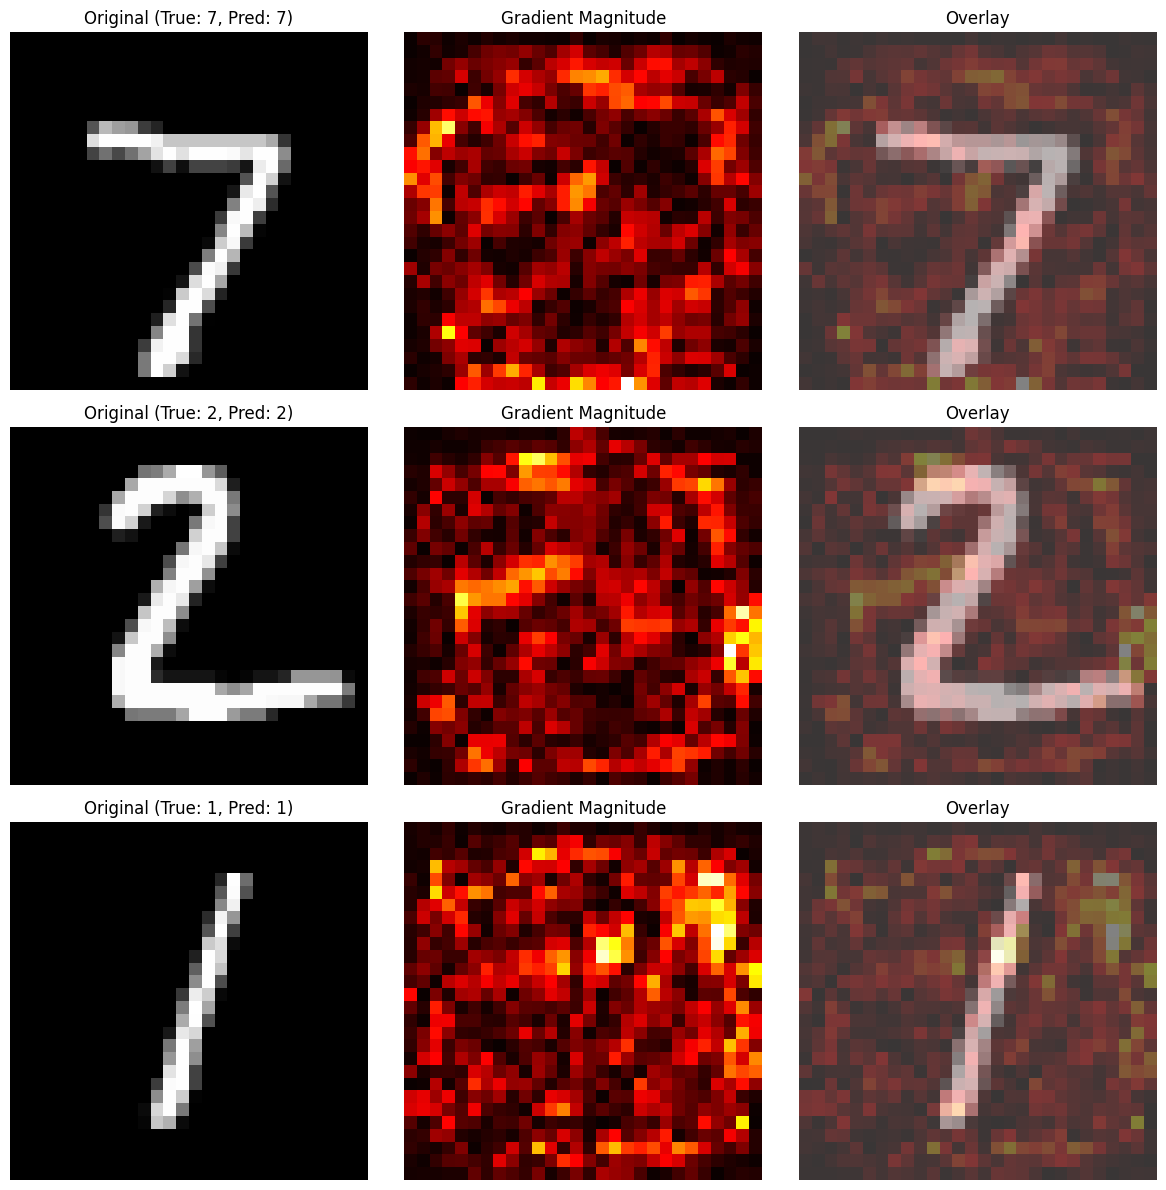

In [29]:
# Simple gradient attribution
print("Simple Gradient Attribution:")
visualize_gradient_attribution(model, test_loader, num_samples=3)

Integrated Gradients vs Simple Gradients:


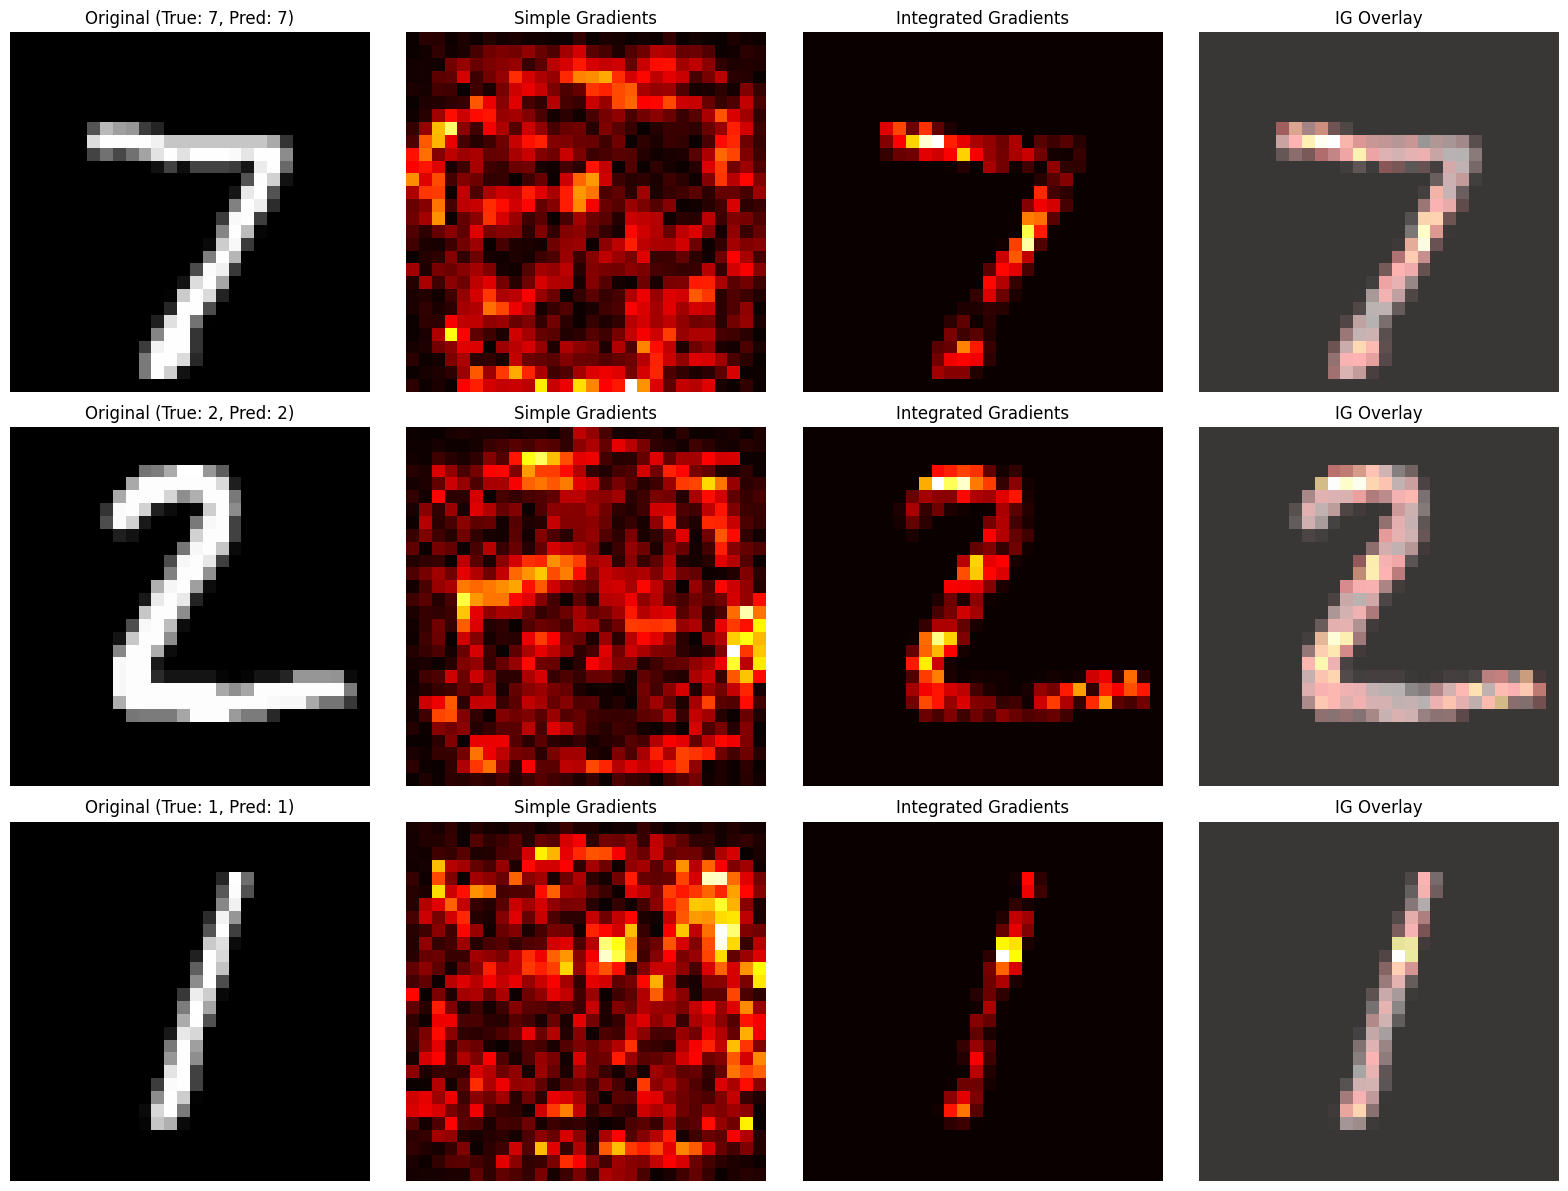

In [30]:
# Integrated gradients
print("Integrated Gradients vs Simple Gradients:")
visualize_integrated_gradients(model, test_loader, num_samples=3)

Comparison of Attribution Methods:


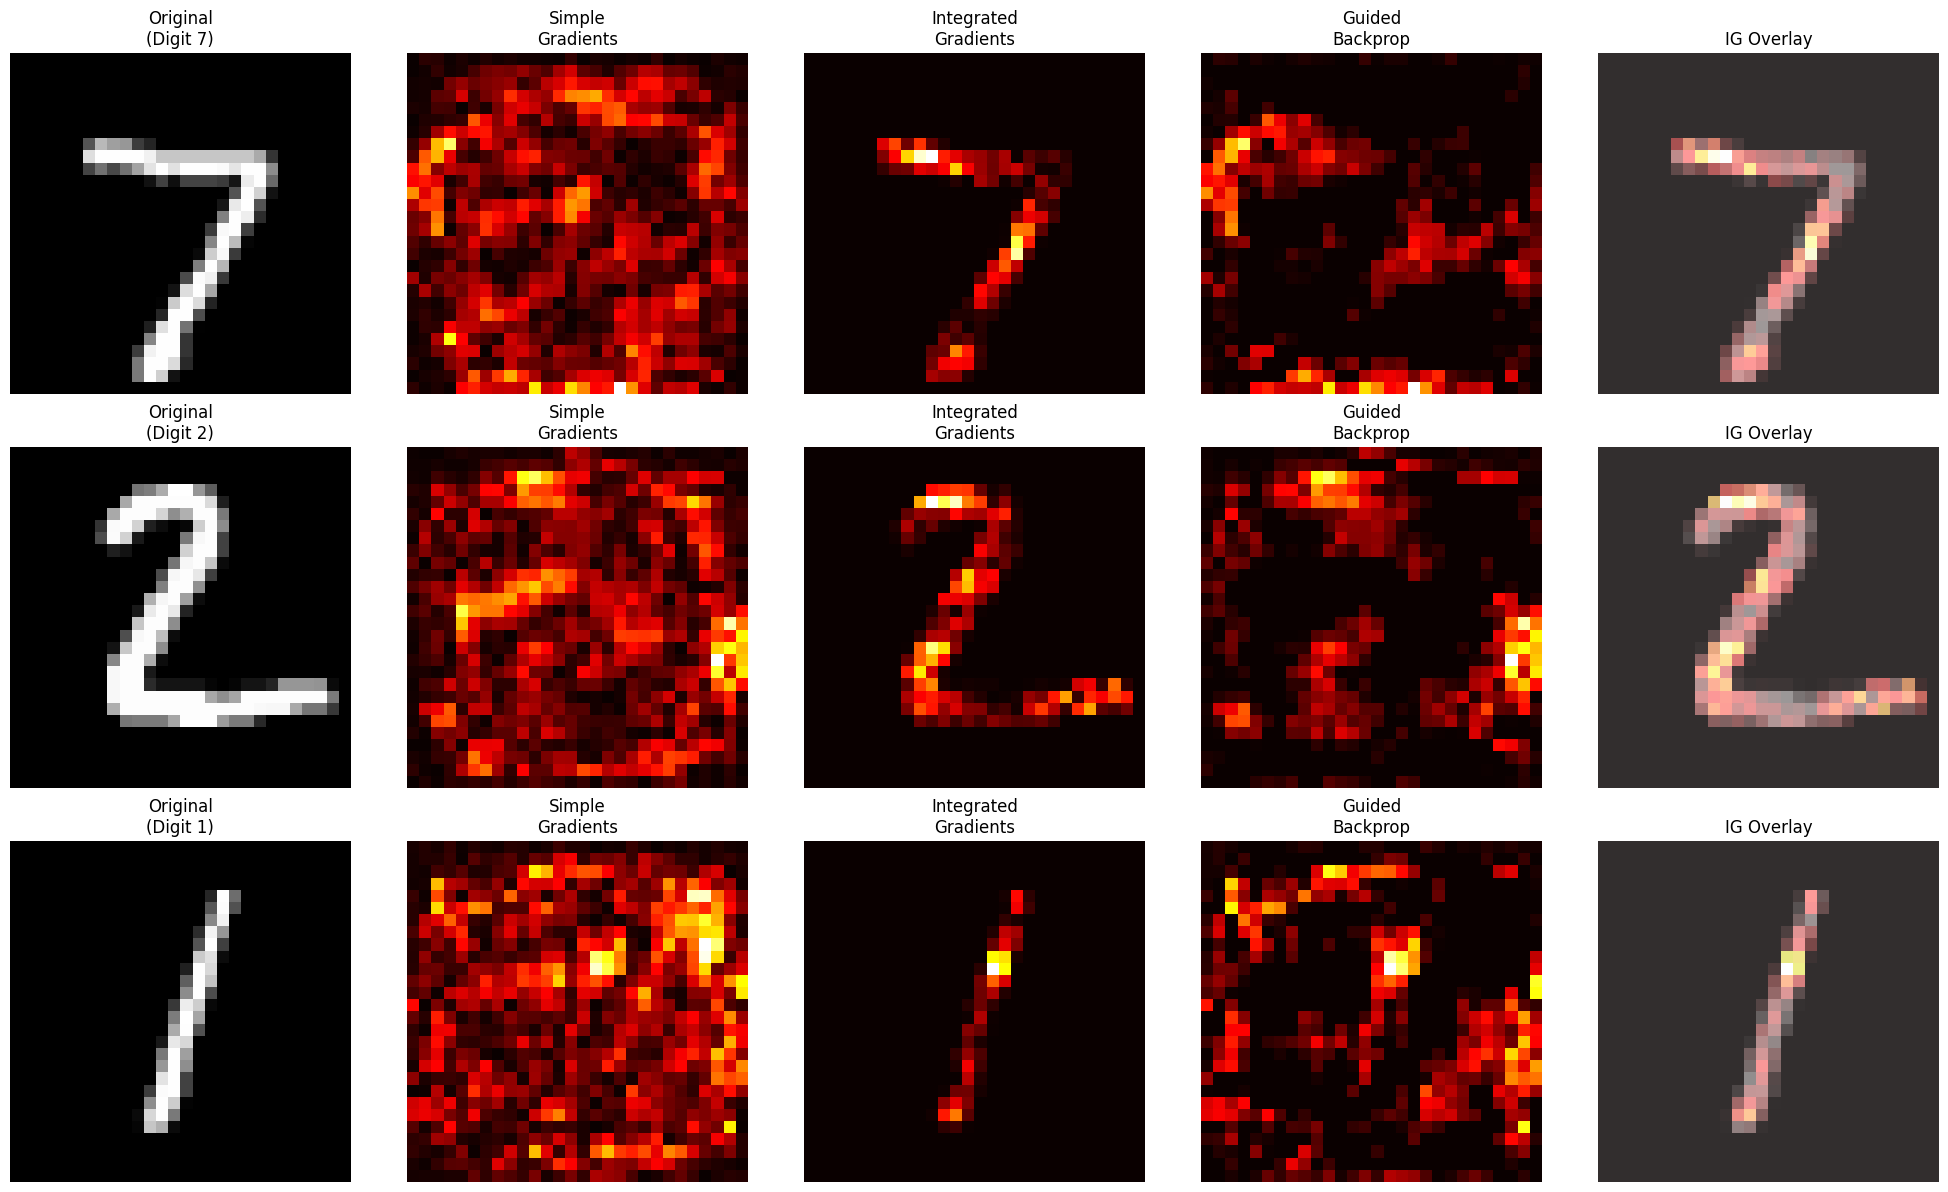

In [31]:
# Compare all methods
print("Comparison of Attribution Methods:")
compare_attribution_methods(model, test_loader, num_samples=3)

## Summary

This notebook demonstrates several gradient-based attribution methods:

1. **Simple Gradients**: Basic gradient of output w.r.t. input
   - Fast and simple
   - Can be noisy and misleading

2. **Integrated Gradients**: Integrates gradients along path from baseline
   - More stable and reliable
   - Satisfies important axioms (sensitivity, implementation invariance)
   - Better handles saturation effects

3. **Guided Backpropagation**: Modified backward pass through ReLUs
   - Focuses on positive contributions
   - Can produce cleaner visualizations

These methods help us understand which input features (pixels) the model considers most important for making specific predictions.